In [1]:
# 라이브러리 호출
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from functools import partial

from skimage.transform import iradon
from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.interpolate import interp1d
from scipy.ndimage import rotate

In [2]:
mat_path = r"./proj_assignment.mat"
mat_data = scipy.io.loadmat(mat_path)
sinogram = mat_data['p']

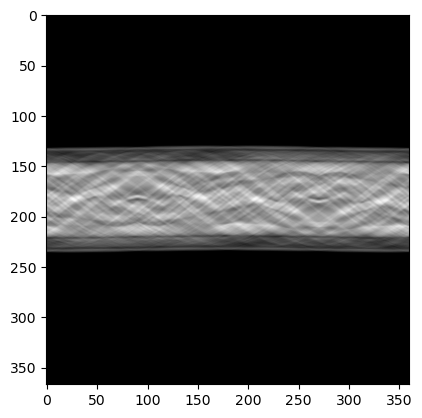

In [3]:
plt.imshow(sinogram, cmap = "gray")

In [4]:
# 각도 정의
theta = np.linspace(0., 360., max(sinogram[1].shape), endpoint=True)
# Filtered Backprojection을 이용한 이미지 재구성
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')

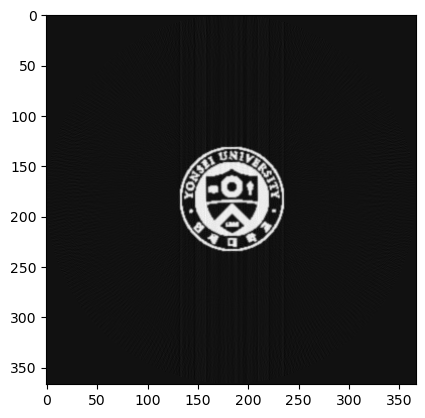

In [5]:
plt.imshow(reconstruction_fbp, cmap = "gray")

In [6]:
def ramp_filter(projection_size):
    freqs = np.fft.fftfreq(projection_size).reshape(-1, 1)  # 주파수 배열 생성
    filter = np.abs(freqs)  # 주파수의 절대값 취하기
    return filter

In [7]:
def iradon_issac(
    radon_image,
    theta=None,
    interpolation="linear",
):

    # 360 angle
    angles_count = len(theta)
    
    interpolation_types = ('linear', 'nearest', 'cubic')

    dtype = radon_image.dtype
    
    img_shape = radon_image.shape[0]
    output_size = int(img_shape)
    
    projection_size_padded = max(64, int(2 ** np.ceil(np.log2(2 * img_shape))))
    pad_width = ((0, projection_size_padded - img_shape), (0, 0))
    img = np.pad(radon_image, pad_width, mode='constant', constant_values=0)


    # 𝐹(𝜌,𝜃) * |𝜌|구현
    # |𝜌|
    fourier_filter = ramp_filter(projection_size_padded)
    # 𝐹(𝜌,𝜃) * |𝜌|
    projection = fft(img, axis=0) * fourier_filter
    radon_filtered = np.real(ifft(projection, axis=0)[:img_shape, :]) 

    # 필터 확인
    plt.title('filtered sinogram')
    plt.imshow(radon_filtered, cmap='gray')
    
    
    # Reconstruct image by interpolation
    reconstructed = np.zeros((output_size, output_size), dtype=dtype)
    radius = output_size // 2
    
    xpr, ypr = np.mgrid[:output_size, :output_size] - radius
    x = np.arange(img_shape) - img_shape // 2

    for col, angle in zip(radon_filtered.T, np.deg2rad(theta)):
        t = ypr * np.cos(angle) - xpr * np.sin(angle)
        
        if interpolation == 'linear':
            interpolant = partial(np.interp, xp=x, fp=col, left=0, right=0)     
        reconstructed += interpolant(t)

    return reconstructed * np.pi / (2 * angles_count)

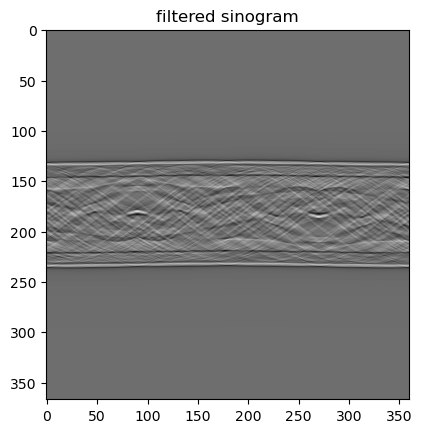

In [8]:
reconstruction_fbp = iradon_issac(sinogram, theta=theta)

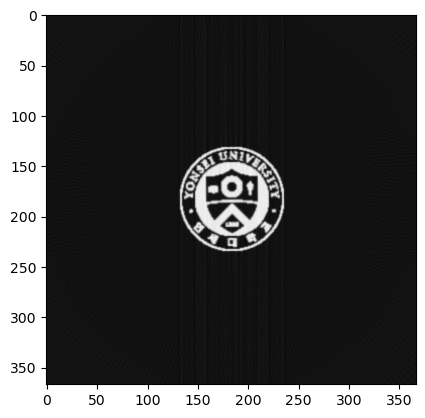

In [9]:
plt.imshow(reconstruction_fbp, cmap = "gray")